In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
import io
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def contains_punctuation(text):
    punctuation = set(string.punctuation)
    for character in text:
        if character in punctuation:
            return True
    return False

def amount_of_punctuation(text):
    punctuation = set(string.punctuation)
    amount = 0
    for character in text:
        if character in punctuation: amount += 1
    return amount

In [4]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv")

In [5]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


In [6]:
tweets_metrics = tweets[['id','text','target']]
tweets_metrics['text_without_stopwords'] = tweets_metrics['text'].str.split()
tweets_metrics['text_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(remove_stopword)

tweets_metrics['length'] = tweets_metrics['text'].apply(lambda x: len(x))
tweets_metrics['avg_word_length'] = tweets_metrics['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_metrics['amount_of_words'] = tweets_metrics['text'].str.split().transform(lambda x: len(x))
unique_words_by_tweet = tweets_metrics['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_metrics['amount_of_unique_words'] = unique_words_by_tweet
tweets_metrics['sentiment'] = tweets_metrics['text'].apply(lambda x: return_sia_compound_values(x))
tweets_metrics['stopwords_count'] = tweets_metrics['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords]))
tweets_metrics['punctuation_count'] = tweets_metrics['text'].apply(lambda x: amount_of_punctuation(x))
mentions = tweets_metrics['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
tweets_metrics['mentions_count'] = mentions['text'].apply(lambda x: len(x))
hashtags = tweets_metrics['text'].str.findall(r'#[^?\s].*?(?=\s|$)')
tweets_metrics['hashtags_count'] = hashtags.apply(lambda x: len(x))
tweets_metrics['longest_word_length_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(lambda x: ([len(word) for word in str(x).lower().split() if not word.startswith('http')])).apply(lambda x: max(x) if len(x) > 0 else 0)

tweets_metrics.head()

,id,text,target,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason May ALLAH Forgive us,69,4.384615,13,13,0.2732,6,1,0,1,7
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Canada,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked notified No evacuation she...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders California,65,7.125000,8,8,0.0000,1,2,0,1,10
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby smoke pours school,88,4.500000,16,15,0.0000,7,2,0,2,6


In [8]:
data_cols = ['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']
x_train, x_test, y_train, y_test = \
train_test_split(tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']], tweets_metrics['target'], test_size = 0.25, random_state = 123)

In [9]:
vectorizer = TfidfVectorizer()
tfidf_lgbm = vectorizer.fit_transform(tweets_metrics.loc[:, 'text'])
array = tfidf_lgbm.todense()

In [10]:
df = pd.DataFrame(array)
df['output'] = tweets['target']
basic_features = tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']]
tfidf_features = df.merge(basic_features, left_index = True, right_index = True)
tfidf_features

,0,1,2,3,4,5,6,7,8,9,...,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69,4.384615,13,13,0.2732,6,1,0,1,7
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,0.0,0.416232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65,7.125000,8,8,0.0000,1,2,0,1,10
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88,4.500000,16,15,0.0000,7,2,0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,136,7.058824,17,17,-0.7579,2,15,0,1,10
7430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105,6.571429,14,14,-0.7579,2,9,0,1,10
7431,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134,5.428571,21,21,0.9164,5,9,0,0,8
7432,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,139,4.384615,26,21,0.4118,9,7,0,0,7


In [11]:
features = tfidf_features.columns.drop('output')
x = tfidf_features.loc[:, features].values
y = tfidf_features.loc[:, 'output'].values

from sklearn.model_selection import train_test_split
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_tfidf_train = sc.fit_transform(x_tfidf_train)
x_tfidf_test = sc.transform(x_tfidf_test)

### KNN : baseline
 *En principio usando un bootstrap del set de entrenamiento para medir accuracy. Se utilizo un 25% del set para entrenar y el 75% restante para la predicción. Se utilizó la representación TF-IDF para el entrenamiento ya que KNN funciona con valores numericos.*
 
Methods

* fit(self, X, y) Fit the model using X as training data and y as target values

* get_params(self[, deep]) Get parameters for this estimator.

* kneighbors(self[, X, n_neighbors, …]) Finds the K-neighbors of a point.

* kneighbors_graph(self[, X, n_neighbors, mode]) Computes the (weighted) graph of k-Neighbors for points in X

* predict(self, X) Predict the class labels for the provided data.

* predict_proba(self, X) Return probability estimates for the test data X.

* score(self, X, y[, sample_weight]) Return the mean accuracy on the given test data and labels.

* set_params(self, \*\*params) Set the parameters of this estimator.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
max = knn.score(x_test, y_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    actual = knn.score(x_test, y_test)
    if max < actual:
        optimo = i
        max = actual

print(optimo, max)

22 0.6853146853146853


### KNN con TF-IDF

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_tfidf_train, y_tfidf_train)
max = knn.score(x_tfidf_test, y_tfidf_test)
actual = max
optimo = 8


print(optimo, max)

8 0.5798458149779736


### KNN con count vectorizer

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
count_vectorizer = vectorizer.fit_transform(tweets_metrics.loc[:, 'text'])
array = count_vectorizer.todense()
count_vectorizer_df = pd.DataFrame(array)
count_vectorizer_df

,0,1,2,3,4,5,6,7,8,9,...,67988,67989,67990,67991,67992,67993,67994,67995,67996,67997
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:

from sklearn.model_selection import train_test_split
x_count_train, x_count_test, y_count_train, y_count_test = train_test_split(count_vectorizer_df, tweets_metrics['target'], test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_count_train = sc.fit_transform(x_count_train)
x_count_test = sc.transform(x_count_test)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_count_train, y_count_train)
max = knn.score(x_count_test, y_count_test)
actual = max
optimo = 8


print(optimo, max)

8 0.584722969338354


### XGBoost

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#acc = 0.7305002689618074(objective ='binary:logistic', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 35,alpha = 0.5, n_estimators = 140) 
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.6, learning_rate = 0.01,
                max_depth = 35,alpha = 0.5, n_estimators = 140) 
xg_reg.fit(x_train,y_train) 
y_pred = xg_reg.predict(x_test)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.7305002689618074


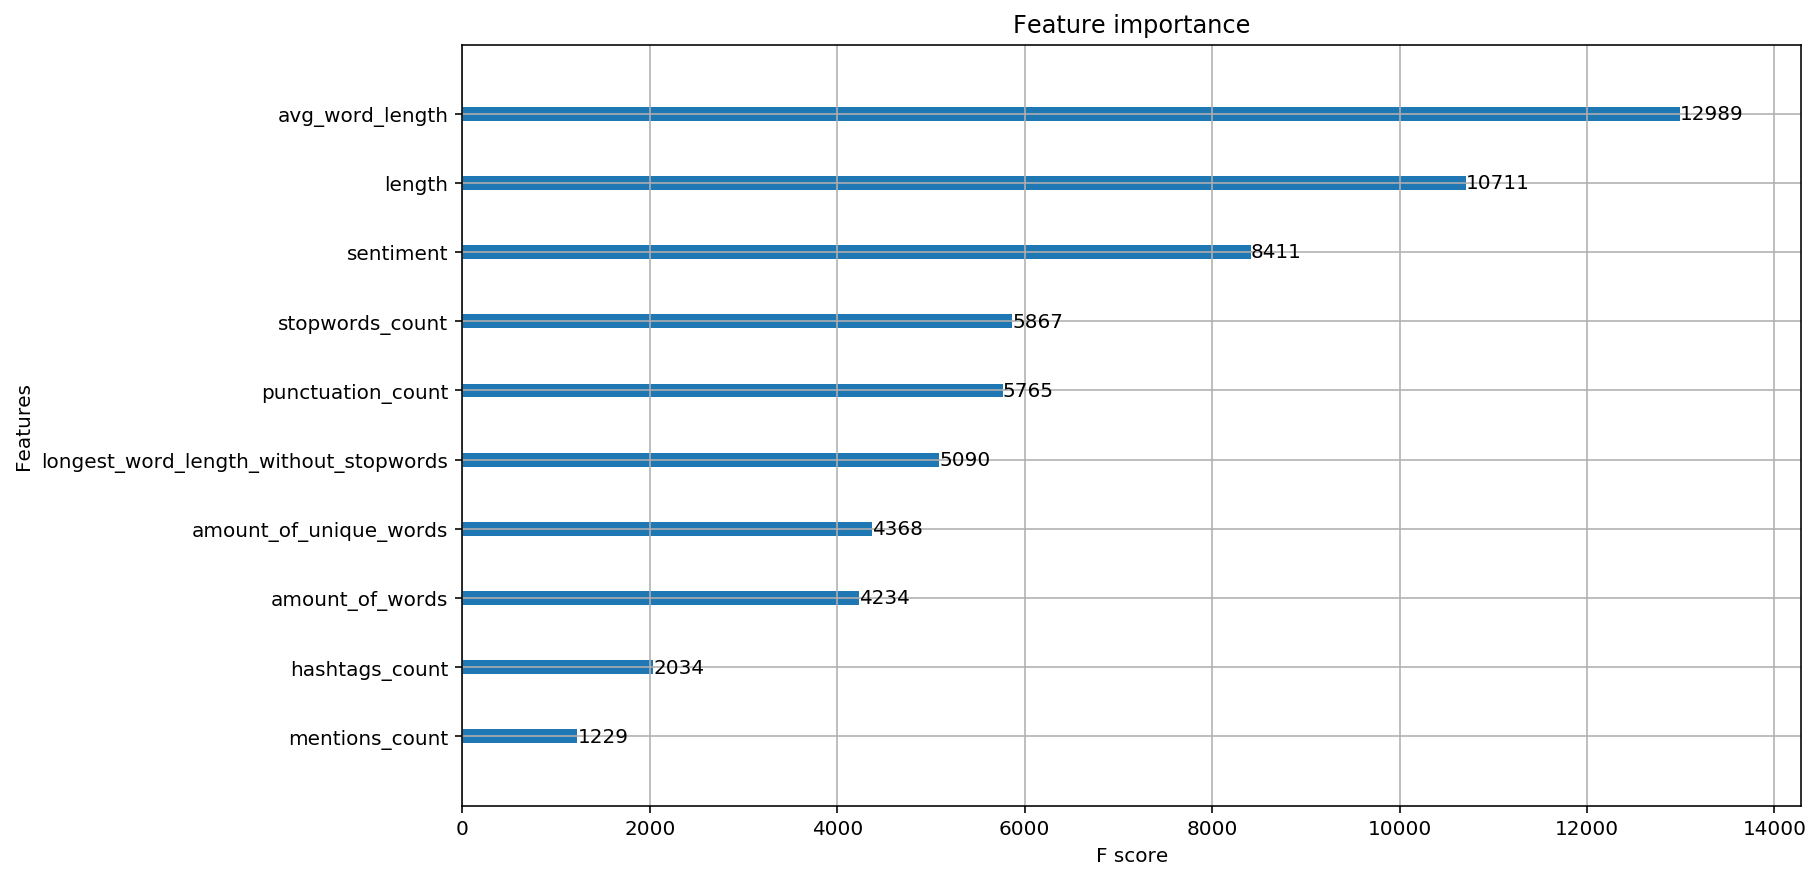

In [18]:
kfold = KFold(n_splits=10)
results = cross_val_score(xg_reg, x_train, y_train, cv=kfold)
results

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

### XGBoost con TF-IDF

In [ ]:
#acu = 0.7296255506607929(objective ='reg:squarederror', colsample_bytree = 0.6, learning_rate = 0.05, max_depth = 15, alpha = 0.5, n_estimators = 50)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                colsample_bytree = 0.6, learning_rate = 0.05,
                max_depth = 15, alpha = 0.5, n_estimators = 50)
xg_reg.fit(x_tfidf_train,y_tfidf_train)
preds = xg_reg.predict(x_tfidf_test)

In [ ]:
for i in range (0, len(preds)):
    if preds[i] >= 0.5:       
        preds[i] = 1 
    else:  
        preds[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_tfidf_test)
print(accuracy)